In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("ggplot")
%matplotlib inline

In [2]:
NTP_df_clean= pd.read_csv('df_NTP_clean.csv', encoding='utf-8-sig')


In [3]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler

scaler = StandardScaler()

In [4]:
from sklearn.utils import resample


We will be dealing with balancing the data below

In [5]:
DrDoS_NTP_label = NTP_df_clean[NTP_df_clean[' Label']==1]
BENIGN_label = NTP_df_clean[NTP_df_clean[' Label']==0]
 
# Upsample minority class
DrDoS_NTP_sample = resample(DrDoS_NTP_label, 
                                 replace=True,     # sample with replacement
                                 n_samples=7400,    # to match BENIGN class
                                 random_state=123) # reproducible results
 

df = pd.concat([BENIGN_label,DrDoS_NTP_sample])
 

df[' Label'].value_counts()

1    7400
0    3402
Name:  Label, dtype: int64

In [7]:
y = df[' Label'].values
X = df.values

In [8]:
np.all(np.isfinite(X))


True

In [9]:
np.any(np.isnan(X))


False

In [10]:
df[' Label'].value_counts()


1    7400
0    3402
Name:  Label, dtype: int64

In [11]:
X_scaled = scaler.fit_transform(X)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size = 0.8, test_size = 0.2, random_state = 0)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [17]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
samp_strat= { 0:2741, 1:5900}
random_under= RandomUnderSampler(sampling_strategy=samp_strat,random_state=1)
X_rus,y_rus = random_under.fit_resample(X_train,y_train)

In [20]:
from imblearn.over_sampling import RandomOverSampler
samp_strat= {  0:2741, 1:5900}
random_under= RandomOverSampler(sampling_strategy=samp_strat,random_state=1)
Xres,yres = random_under.fit_resample(X_rus,y_rus)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

In [24]:
from sklearn.ensemble import RandomForestClassifier


In [25]:
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

<AxesSubplot:>

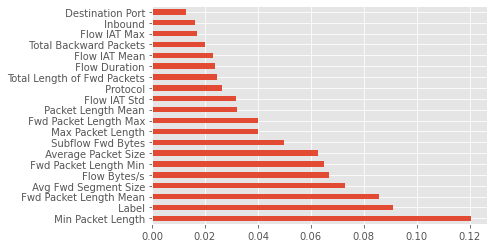

In [26]:
(pd.Series(model.feature_importances_, index=df.columns)
   .nlargest(20)
   .plot(kind='barh'))

In [27]:
import seaborn as sns


We have below variables which are higly correlated > 0.8 which will cause real problem, to fix it we will be performing PCA



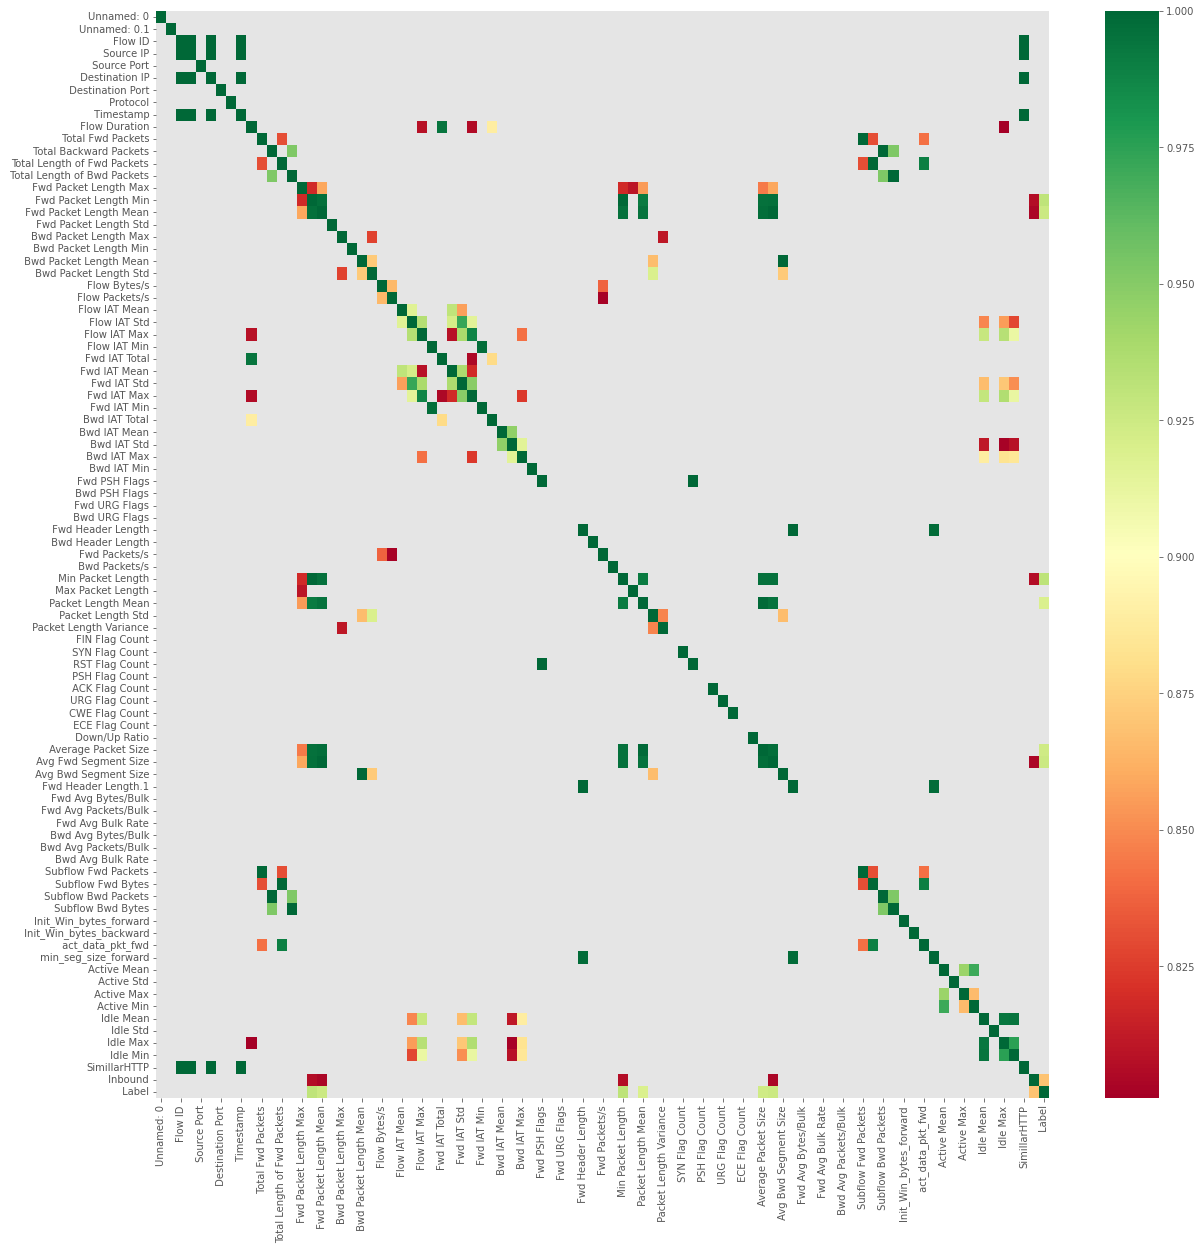

In [28]:
corrmat = df.corr()
top_corr_features = corrmat[corrmat>=.8]
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(top_corr_features,cmap="RdYlGn")
        

In [29]:
corre = df.corr()


In [30]:
cor_target = abs(df[" Label"])


In [31]:
relevant_features = cor_target[cor_target>0.5]
relevant_features

4970721    1
279629     1
4224884    1
3165795    1
1243074    1
          ..
4287462    1
3478926    1
3204439    1
113610     1
1375644    1
Name:  Label, Length: 7400, dtype: int64

In [32]:
df.corr()


,Unnamed: 0,Unnamed: 0.1,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
Unnamed: 0,1.000000,0.224624,-0.021485,-0.021485,-0.188607,-0.021485,0.101836,0.144167,-0.021485,-0.074499,...,-0.015001,-0.041299,-0.043204,-0.081803,-0.029214,-0.082146,-0.080114,-0.021485,0.184865,0.214474
Unnamed: 0.1,0.224624,1.000000,-0.170332,-0.170332,-0.347627,-0.170332,0.191798,0.376463,-0.170332,-0.189688,...,-0.056699,-0.078108,-0.056692,-0.147923,-0.056940,-0.149145,-0.144297,-0.170332,0.364580,0.438559
Flow ID,-0.021485,-0.170332,1.000000,1.000000,0.014223,1.000000,0.001563,0.047767,1.000000,-0.002923,...,0.017433,0.019143,0.016995,0.006534,-0.010469,0.005024,0.008069,1.000000,0.017342,0.014184
Source IP,-0.021485,-0.170332,1.000000,1.000000,0.014223,1.000000,0.001563,0.047767,1.000000,-0.002923,...,0.017433,0.019143,0.016995,0.006534,-0.010469,0.005024,0.008069,1.000000,0.017342,0.014184
Source Port,-0.188607,-0.347627,0.014223,0.014223,1.000000,0.014223,-0.635708,-0.451134,0.014223,0.244935,...,0.045432,0.108314,0.101900,0.225185,0.036255,0.220859,0.225943,0.014223,-0.941646,-0.827275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle Max,-0.082146,-0.149145,0.005024,0.005024,0.220859,0.005024,-0.153537,-0.268168,0.005024,0.800866,...,0.200868,0.209759,0.148926,0.993360,0.381023,1.000000,0.975500,0.005024,-0.236528,-0.215726
Idle Min,-0.080114,-0.144297,0.008069,0.008069,0.225943,0.008069,-0.150047,-0.258950,0.008069,0.780520,...,0.187262,0.198631,0.144698,0.994074,0.172505,0.975500,1.000000,0.008069,-0.231225,-0.211316
SimillarHTTP,-0.021485,-0.170332,1.000000,1.000000,0.014223,1.000000,0.001563,0.047767,1.000000,-0.002923,...,0.017433,0.019143,0.016995,0.006534,-0.010469,0.005024,0.008069,1.000000,0.017342,0.014184
Inbound,0.184865,0.364580,0.017342,0.017342,-0.941646,0.017342,0.664488,0.560206,0.017342,-0.282716,...,-0.082380,-0.116264,-0.086951,-0.235749,-0.081048,-0.236528,-0.231225,0.017342,1.000000,0.869026


Here we had to use PCA after standrizing the data and get over .95 of the explained varaince



In [33]:

from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(X_scaled)
reduced = pca.transform(X_scaled)

total length =  2161
BENIGN =  1500
DrDoS_NTP =  661


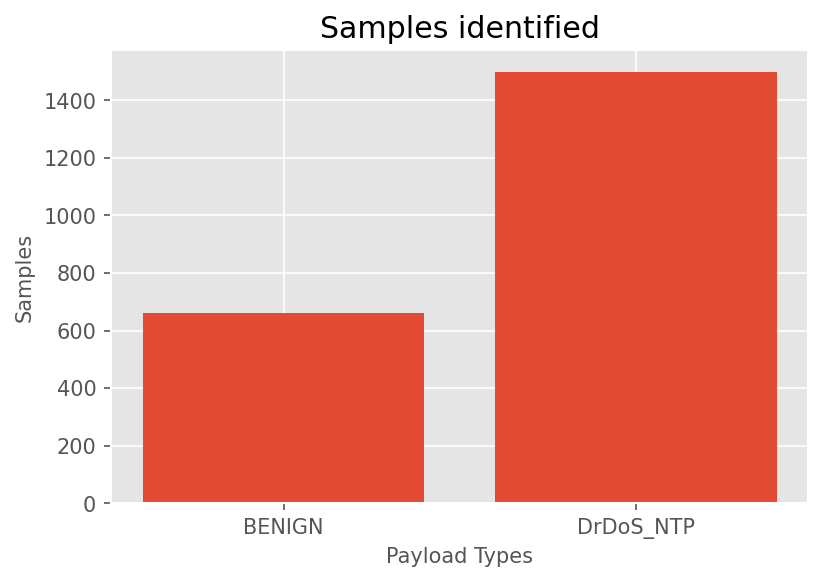

In [34]:
checking_occurences = [X for X in y_test if X == 1]
print("total length = ",len(y_test))
print("BENIGN = ",len(checking_occurences))
print("DrDoS_NTP = ", (len(y_test) - len(checking_occurences)))
n = len(y_test) - len(checking_occurences)
a = len(checking_occurences)

label = ['BENIGN', 'DrDoS_NTP']
samples = [n, a]

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi * 1.5

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, samples)
plt.xlabel('Payload Types', fontsize=10)
plt.ylabel('Samples', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=0)
plt.title('Samples identified')
plt.show()

In [35]:

from sklearn.ensemble import IsolationForest
iForest = IsolationForest()

In [36]:
df[' Label'].value_counts()


1    7400
0    3402
Name:  Label, dtype: int64

In [37]:
iForest.fit(X_train)


IsolationForest()

In [38]:
#scores = iForest.decision_function(X_val)


In [39]:
#scores


In [40]:
#plt.figure(figsize=(12,8))
#plt.hist(scores, bins=100);

In [41]:
cutoff = -0.07


In [42]:
df['log2_value1'] = np.log2(df[' Flow Duration'])
df['log2_value2'] = np.log2(df[' Source IP'])
df['log2_value3'] = np.log2(df[' Destination IP'])
df['log2_value3'] = np.log2(df[' Destination Port'])
df['log2_value3'] = np.log2(df[' Protocol'])

print(df)

divide by zero encountered in log2


         Unnamed: 0  Unnamed: 0.1  Flow ID   Source IP   Source Port  \
27               27           123     2558        2558         59099   
31               31            23    14446       14446         59102   
53               53           126     2891        2891             0   
93               93            91    27184       27184         59155   
94               94            87    26739       26739         59131   
...             ...           ...      ...         ...           ...   
4287462     4287462         26053    17840       17840           767   
3478926     3478926         17889     8767        8767           604   
3204439     3204439         23104    14564       14564           867   
113610       113610         18414     9352        9352           666   
1375644     1375644         23822    15361       15361          1001   

          Destination IP   Destination Port   Protocol   Timestamp  \
27                  2558                 80          6        255

In [44]:
from xgboost import XGBClassifier
model_1 = XGBClassifier(random_state = 42)
model_1.fit(Xres,yres)
pred_1 = model_1.predict(X_test)
score1 = model_1.score(X_test,y_test)
print("Accuracy of base model: ",score1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of base model:  1.0


In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
params={'max_depth':[5], 'n_estimators': [200,300,400],
            'learning_rate': [0.15,0.20], 'subsample':[0.3,0.5,0.7]}

In [47]:
model_2 = GridSearchCV(XGBClassifier(),params,refit=True,verbose=3)


In [48]:
model_2.fit(Xres,yre)


NameError: name 'yre' is not defined

In [49]:
model_2.best_params_


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
model_2.best_estimator_


In [ ]:
pred_2 = model_2.predict(X_test)


In [ ]:
score_2 = model_2.score(X_test,y_test)
print("Accuracy of 1st test model: ",score_2*100)

In [ ]:

params_new={'max_depth':[4], 'n_estimators': [200,300],
           'learning_rate': [0.05,0.1], 'subsample':[0.5,0.7]}

In [ ]:
model_3 = GridSearchCV(XGBClassifier(),params_new,refit=True,verbose=3,
                       n_jobs=-1)

In [ ]:
model_3.fit(Xres,yres)

In [ ]:
from tensorflow import keras
import numpy as np
import datetime
import time
x=pd.DataFrame(reduced)
x = x.values
sample = x.shape[0]
features = x.shape[1]
#Train: convert 2D to 3D for input RNN
x_train = np.reshape(x,(sample,features,1)) #shape  = (125973, 18, 1)
#Test: convert 2D to 3D for input RNN
x_test=pd.DataFrame(X_test)
x_test = x_test.values
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding,SimpleRNN, GRU,Activation,Flatten
from sklearn.metrics import (precision_score, recall_score,confusion_matrix,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras import callbacks
import scikitplot as skplt

### RNN

In [ ]:

batch_size = 32
model_rnn = Sequential()
model_rnn.add(SimpleRNN(8,input_shape=(features,x_train.shape[2]), return_sequences=True))  
model_rnn.add(Dropout(0.1))
model_rnn.add(SimpleRNN(8, return_sequences=False))  
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(1))
model_rnn.add(Activation('sigmoid'))

In [ ]:

model_rnn.compile(loss='binary_crossentropy',optimizer='Adadelta',metrics=['acc'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) 
Echeckpointer = callbacks.ModelCheckpoint(filepath="RNN-checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
model_rnn.fit(x_train, y, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test),callbacks=[es])
model_rnn.save("best_model_rnn.hdf5")

In [ ]:
scores = model_rnn.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
y_pred_rnn = model_rnn.predict_classes(x_test)
y_probs_rnn=model_rnn.predict_proba(x_test)
np.savetxt('rnn_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_rnn), axis=1)), fmt='%01d')
np.savetxt('rnn_prob_predictions.txt', np.around(np.transpose(y_probs_rnn),decimals=5), fmt='%.5f')

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rnn)
plt.title("RNN-Confusion Matrix")
plt.rcParams['figure.figsize']=(5,4)
plt.show()

In [ ]:
batch_size=32


### LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(8,input_shape=(features,x_train.shape[2]), return_sequences=True))  
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(8, return_sequences=False))  
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.add(Activation('sigmoid'))

In [ ]:

model_lstm.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['acc'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing


model_lstm.fit(x_train, y, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test),callbacks=[es])
model_lstm.save("lstm_model_lstm.hdf5")

In [ ]:
y_pred_lstm = model_lstm.predict_classes(x_test)
y_probs_lstm=model_lstm.predict_proba(x_test)
np.savetxt('lstm_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_lstm), axis=1)), fmt='%01d')
np.savetxt('lstm_prob_predictions.txt', np.around(np.transpose(y_probs_lstm),decimals=5), fmt='%.5f')


######Plot confusion matrix

skplt.metrics.plot_confusion_matrix(y_test, y_pred_lstm)
plt.title("LSTM-Confusion Matrix")
plt.show()

In [ ]:
scores = model_lstm.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
accuracy = accuracy_score(y_test, y_pred_lstm)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_lstm)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_lstm)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_lstm)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_lstm)
print("Recall_score:",rs)